In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pykitti
import sys
from sklearn.metrics import mean_squared_error

%matplotlib inline
np.random.seed(777)

In [2]:
sys.path.append('./src')

from filterpy.kalman import KalmanFilter
from utils import lla_to_enu, normalize_angles

ModuleNotFoundError: No module named 'utils'

In this notebook, Kalman filter is introduced to the Kitti dataset.
Kalman filter is a recursive algorithm to estimate next state space, where the system is assumed to be linear meaning that the relation between current state and previous state is represented in linear equation.
The state space vector x is defined such that:

$$\mathbf x = \begin{bmatrix}\mathtt{x} \\\mathtt{y}\\ \mathtt{\dot x}\\ \mathtt{\dot y}\end{bmatrix}$$

In prediction step, current state space vector $x_{k}$ is obtained from the equation:
$$\mathbf 
    {\hat{x_{k}^{-}}} = F_{k}*\hat{x_{k-1}} + B*u_{k}
$$

According to basics of kinematics, displacement and velocity is calculated based on the following equations:

$$\begin{aligned}
    x_{t} &= x_{t-1} + \Delta{t}*\dot{v} \\
    v_{t} &= v_{t-1} + \Delta{t}*\ddot{v}
\end{aligned}$$
where; $\dot{v}$ and $\ddot{v}$ represent linear velocity and accelearation respectively.

According to the equation above, we acquire the current state space vector $x_{k}$ as shown below.
$$\mathbf 
    {\hat{x_{k}^{-}}} = F_{k}*\hat{x_{k-1}} + B*u_{k} = 
    \begin{bmatrix}
        \mathtt{x_{k-1} + \Delta{t} * \dot{x}_{k-1}} \\
        \mathtt{y_{k-1} + \Delta{t} * \dot{y}_{k-1}}\\ 
        \mathtt{\dot x_{k-1} + \Delta{t}* \ddot{x}}\\ 
        \mathtt{\dot y_{k-1} + \Delta{t}* \ddot{y}}
    \end{bmatrix}
$$

## Load raw data 0020

In [3]:
kitti_root_dir = 'data'
kitti_date = '2011_09_30'
kitti_drive = '0020'

dataset = pykitti.raw(kitti_root_dir, kitti_date, kitti_drive)

In [4]:
gt_trajectory_lla = []  # [longitude(deg), latitude(deg)] x N
gt_accelerations = [] # [acceleration in x, acceleration in y] x N

for oxts_data in dataset.oxts:
    packet = oxts_data.packet
    gt_trajectory_lla.append([
        packet.lon,
        packet.lat,
        packet.alt
    ])
    gt_accelerations.append([
        packet.ax,
        packet.ay
    ])

gt_trajectory_lla = np.array(gt_trajectory_lla).T
gt_accelerations = np.array(gt_accelerations).T

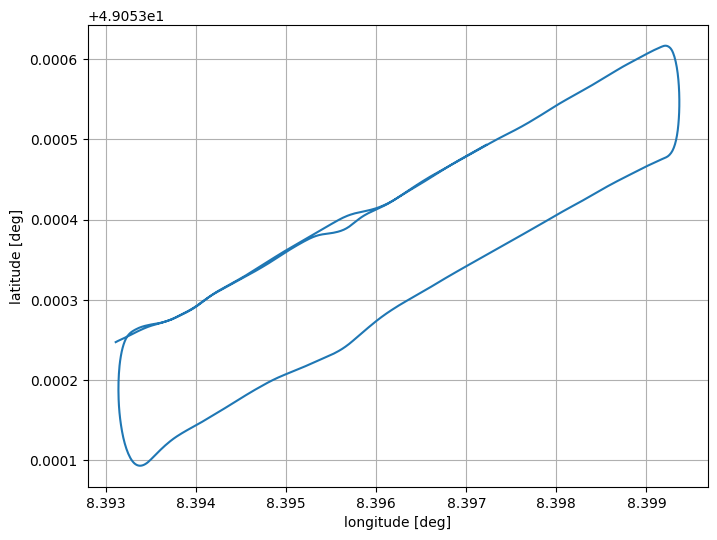

In [5]:
lons, lats, _ = gt_trajectory_lla

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(lons, lats)
ax.set_xlabel('longitude [deg]')
ax.set_ylabel('latitude [deg]')
ax.grid()

Transform GPS trajectory from [lon, lat] to local [x, y] coord so that Kalman filter can handle it.

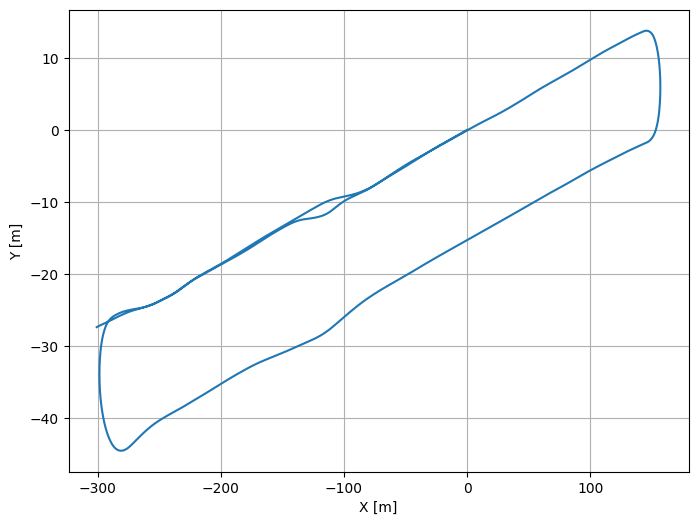

In [6]:
origin = gt_trajectory_lla[:, 0]  # set the initial position to the origin
gt_trajectory_xyz = lla_to_enu(gt_trajectory_lla, origin)

xs, ys, _ = gt_trajectory_xyz
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(xs, ys)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.grid()

Extract timestamps from KITTI data and convert them to seconds elapsed from the first one.

In [7]:
timestamps = np.array(dataset.timestamps)
elapsed = np.array(timestamps) - timestamps[0]
ts = [t.total_seconds() for t in elapsed] # dt

## Adding gaussian noise to KITTI GPS/IMU data

This is referred as measurement noise. 
we will have noise for covariance of:
 - x and y values obtained from GPS sensor

These noise, gaussian white noise, are used for the initial value of covariance vector P and constant process noise Q in time update step, and measurement noise R in correction state.


sigma_x_y = standard deviation of normal distribution (gaussian noise for x and y coordinates)
var_x_y = sigma_x_y ** 2
acceleration_noise_std = standard deviation of normal distribution (gaussian noise for ax and ay acceleration)
var_acc_x_y = acceleration_noise_std ** 2

covariance matrix for state variable:
```
P = [
  0.1 0 0 0
  0 0.1 0 0
  0 0 0.1 0
  0 0 0 0.1
]
```

process noise: (zero mean gaussian distribution)
```
Q = [
  var_x_y     0 0 0
  0 var_x_y     0 0
  0 0 var_acc_x_y 0
  0 0 0 var_acc_x_y
]
```

measurement noise (gaussian noise for x and y coordinate):
```
R = [
  var_x_y   0 0 0
  0 var_x_y   0 0
]
```


In [8]:
N = len(ts)  # number of data point

### Add noise to GPS data

In [55]:
xy_obs_noise_std = 1.0  # standard deviation of observation noise of x and y in meter. so 95% of x and y values fall inside +- 2m from the ground truth.

xy_obs_noise = np.random.normal(0.0, xy_obs_noise_std, (2, N))  # gen gaussian noise
obs_trajectory_xyz = gt_trajectory_xyz.copy()
obs_trajectory_xyz[:2, :] += xy_obs_noise  # add the noise to ground-truth x and y positions

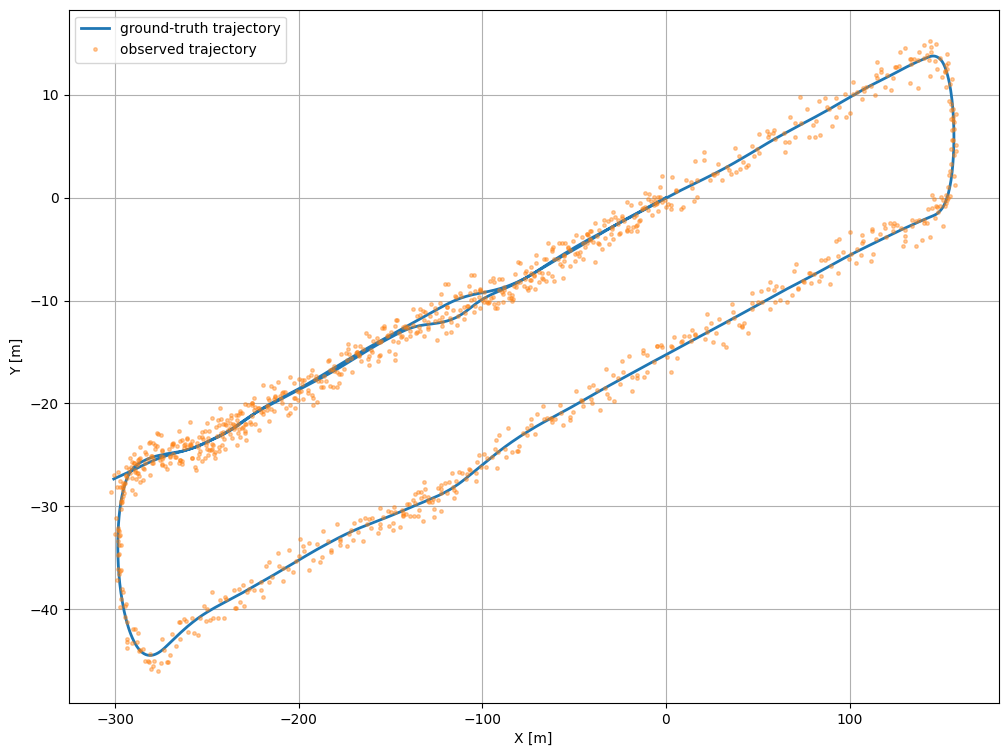

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

xs, ys, _ = gt_trajectory_xyz
ax.plot(xs, ys, lw=2, label='ground-truth trajectory')

xs, ys, _ = obs_trajectory_xyz
ax.plot(xs, ys, lw=0, marker='.', markersize=5, alpha=0.4, label='observed trajectory')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()
ax.grid()

### Adding noise to the Acceleration

In [57]:
acceleration_noise_std = 0.1 # standard deviation of acceleration in m/s^2

acceleration_noise = np.random.normal(0.0, acceleration_noise_std, (N,))  # gen gaussian noise
accelerations_with_measurement_noise = gt_accelerations.copy()
accelerations_with_measurement_noise += acceleration_noise  # add the noise to ground-truth positions

In [58]:
gt_accelerations.shape

(2, 1104)

In [59]:
len(ts)

1104

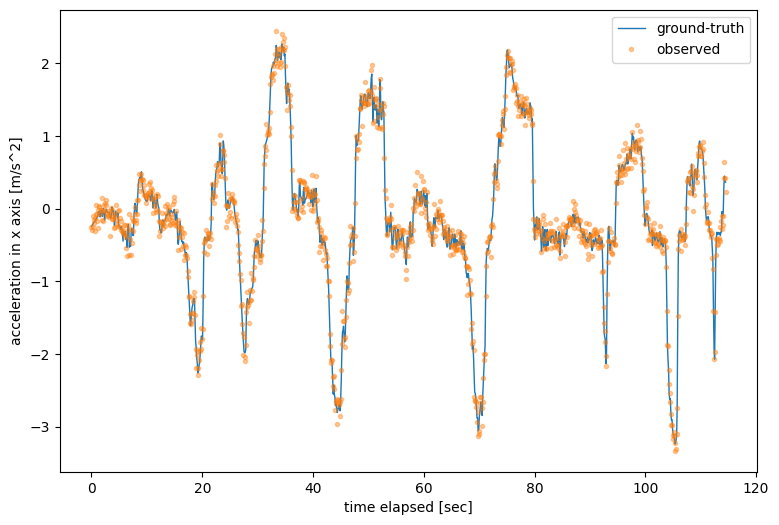

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(ts, gt_accelerations[0, :], lw=1, label='ground-truth')
ax.plot(ts, accelerations_with_measurement_noise[0, :], lw=0, marker='.', alpha=0.4, label='observed')

ax.set_xlabel('time elapsed [sec]')
ax.set_ylabel('acceleration in x axis [m/s^2]')
ax.legend()

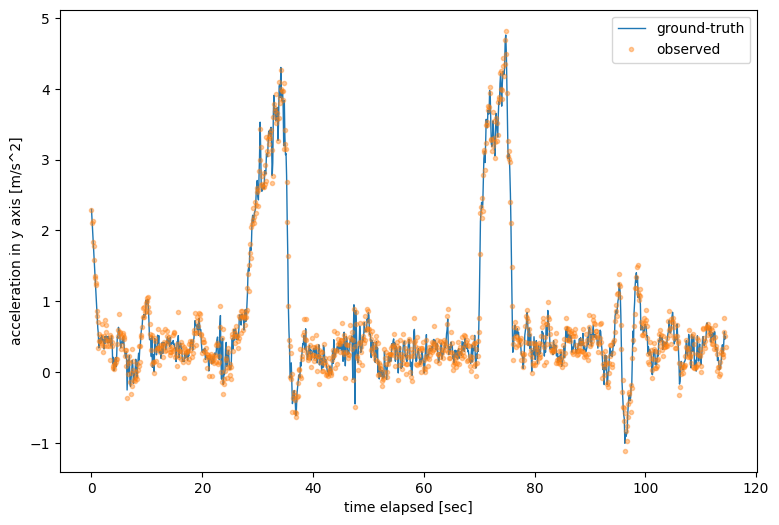

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(ts, gt_accelerations[1, :], lw=1, label='ground-truth')
ax.plot(ts, accelerations_with_measurement_noise[1, :], lw=0, marker='.', alpha=0.4, label='observed')

ax.set_xlabel('time elapsed [sec]')
ax.set_ylabel('acceleration in y axis [m/s^2]')
ax.legend()

In [62]:
dt = np.mean([v1 - v0 for v0, v1 in zip(ts[:-2], ts[1:])])
print(dt)

0.10379191833030853


## Applying Kalman Filter

In [63]:
# we set initial velocity equal to 0 in both x and y axis
x = np.array([
  obs_trajectory_xyz[0, 0], # position in x axis
  obs_trajectory_xyz[1, 0], # position in y axis
  0, # velocity in x axis
  0, # velocity in y axis
])

In [64]:
# covariance for estimation error
noise = 10000
P = np.array([
  [noise, 0., 0., 0.],
  [0., noise, 0., 0.],
  [0., 0., noise, 0.],
  [0., 0., 0., noise],
])

# process noise
Q = np.array([
  [xy_obs_noise_std ** 2., 0., 0., 0.],
  [0., xy_obs_noise_std ** 2., 0., 0.],
  [0., 0., acceleration_noise_std ** 2., 0.],
  [0., 0., 0., acceleration_noise_std ** 2.],
])

# measurement noise
R = np.array([
  [xy_obs_noise_std ** 2., 0.],
  [0., xy_obs_noise_std ** 2.],
])

In [65]:
kf = KalmanFilter(dim_x=4, dim_z=2)
# state space vector x
kf.x = x

# state-to-measurement matrix (observation matrix)
kf.H = np.array([
                  [1, 0, 0, 0],
                  [0, 1, 0, 0],
                ])
# covariance matrix of state vector x
kf.P = P.copy()
# measurement noise
kf.R = R.copy()
# process noise 
kf.Q = Q.copy()

In [66]:
t_last = 0.
mu_x = [kf.x[0],]
mu_y = [kf.x[1],]
for t_idx in range(1, N):
    t = ts[t_idx]
    dt = t - t_last
    # state transition matrix F
    kf.F = np.array([
                  [1, 0, dt, 0],
                  [0, 1, 0, dt],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]
                ])
    kf.u = accelerations_with_measurement_noise[:, t_idx]
    kf.B = np.array([
        [0, 0],
        [0, 0],
        [dt, 0],
        [0, dt]
    ])
    print(kf.P)
    kf.predict()
    z = obs_trajectory_xyz[:2, t_idx]
    kf.update(z)
    mu_x.append(kf.x[0])
    mu_y.append(kf.x[1])
    t_last = t

[[10000.     0.     0.     0.]
 [    0. 10000.     0.     0.]
 [    0.     0. 10000.     0.]
 [    0.     0.     0. 10000.]]
[[9.99900916e-01 0.00000000e+00 9.42094849e-02 0.00000000e+00]
 [0.00000000e+00 9.99900916e-01 0.00000000e+00 9.42094849e-02]
 [9.42094849e-02 0.00000000e+00 9.91043562e+03 0.00000000e+00]
 [0.00000000e+00 9.42094849e-02 0.00000000e+00 9.91043562e+03]]
[[  0.98920183   0.          10.17585216   0.        ]
 [  0.           0.98920183   0.          10.17585216]
 [ 10.17585216   0.         321.04290245   0.        ]
 [  0.          10.17585216   0.         321.04290245]]
[[  0.87222822   0.           5.20034836   0.        ]
 [  0.           0.87222822   0.           5.20034836]
 [  5.20034836   0.         109.39721443   0.        ]
 [  0.           5.20034836   0.         109.39721443]]
[[ 0.79381735  0.          3.2168052   0.        ]
 [ 0.          0.79381735  0.          3.2168052 ]
 [ 3.2168052   0.         59.21950067  0.        ]
 [ 0.          3.2168052   

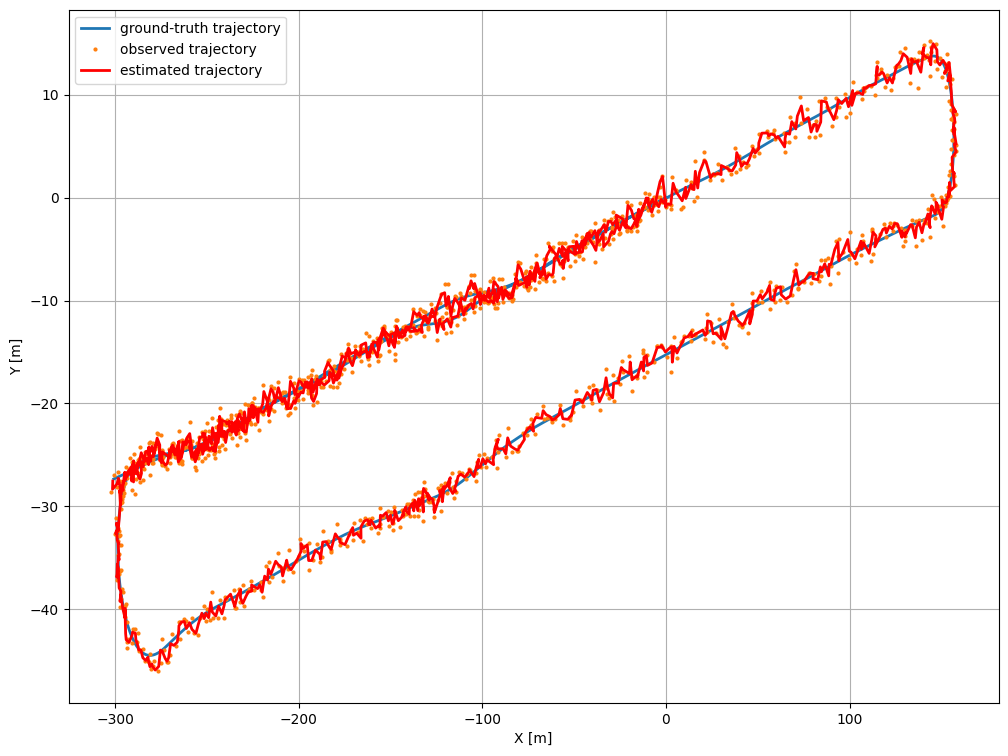

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

xs, ys, _ = gt_trajectory_xyz
ax.plot(xs, ys, lw=2, label='ground-truth trajectory')

xs, ys, _ = obs_trajectory_xyz
ax.plot(xs, ys, lw=0, marker='.', markersize=4, alpha=1., label='observed trajectory')

ax.plot(mu_x, mu_y, lw=2, label='estimated trajectory', color='r')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()
ax.grid()

In [340]:
error_kf = mean_squared_error(gt_trajectory_xyz[:2, :], np.array([mu_x, mu_y]))
print(f"MSE: {error_kf}")

MSE: 0.5565192570559592


In [341]:

class KalmanFilter_original(object):
    F = None
    B = None
    def __init__(self, F, B, H = None, Q = None, R = None, P = None, x0 = None):

        if(F is None or H is None):
            raise ValueError("Set proper system dynamics.")

        self.n = F.shape[1]
        self.m = H.shape[1]

        self.F = F
        self.H = H
        self.B = 0 if B is None else B
        self.Q = np.eye(self.n) if Q is None else Q
        self.R = np.eye(self.n) if R is None else R
        self.P = np.eye(self.n) if P is None else P
        self.x = np.zeros((self.n, 1)) if x0 is None else x0

    def predict(self, u = 0):
        self.x = np.dot(self.F, self.x) + np.dot(self.B, u)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
        return self.x

    def update(self, z):
        y = z - np.dot(self.H, self.x)
        S = self.R + np.dot(self.H, np.dot(self.P, self.H.T))
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, y)
        I = np.eye(self.n)
        self.P = np.dot(np.dot(I - np.dot(K, self.H), self.P), 
        	(I - np.dot(K, self.H)).T) + np.dot(np.dot(K, self.R), K.T)


In [342]:
F = np.array([
      [1, 0, 1, 0],
      [0, 1, 0, 1],
      [0, 0, 1, 0],
      [0, 0, 0, 1]
    ])
B = np.array([
        [0, 0],
        [0, 0],
        [dt, 0],
        [0, dt]
    ])
H = np.array([
      [1, 0, 0, 0],
      [0, 1, 0, 0],
    ])

# covariance for estimation error
p_init = 0.1
P = np.array([
  [p_init, 0., 0., 0.],
  [0., p_init, 0., 0.],
  [0., 0., p_init, 0.],
  [0., 0., 0., p_init],
])
xy_coord_noise = xy_obs_noise_std
a_noise = acceleration_noise_std
# xy_coord_noise = 100
# a_noise = 100
# process noise
Q = np.array([
  [xy_coord_noise ** 2., 0., 0., 0.],
  [0., xy_coord_noise ** 2., 0., 0.],
  [0., 0., a_noise ** 2., 0.],
  [0., 0., 0., a_noise ** 2.],
])

# measurement noise
R = np.array([
  [xy_coord_noise ** 2., 0.],
  [0., xy_coord_noise ** 2.],
])
kf2 = KalmanFilter_original(F=F.copy(), B=B.copy(),
                            H=H.copy(), Q=Q.copy(), R=R.copy(),
                            P=P.copy(), x0=x.copy())

In [343]:
mu_x_2 = [kf2.x[0],]
mu_y_2 = [kf2.x[1],]
t_last = 0.
for t_idx in range(1, N):
    t = ts[t_idx]
    dt = t - t_last
    kf2.F = np.array([
      [1, 0, dt, 0],
      [0, 1, 0, dt],
      [0, 0, 1, 0],
      [0, 0, 0, 1]
    ])
    kf2.B = np.array([
        [0, 0],
        [0, 0],
        [dt, 0],
        [0, dt]
    ])
    x_hat = np.dot(H, kf2.predict(u=accelerations_with_measurement_noise[:, t_idx]))
    mu_x_2.append(x_hat[0])
    mu_y_2.append(x_hat[1])
    z = obs_trajectory_xyz[:2, t_idx]
    kf2.update(z)
    t_last = t

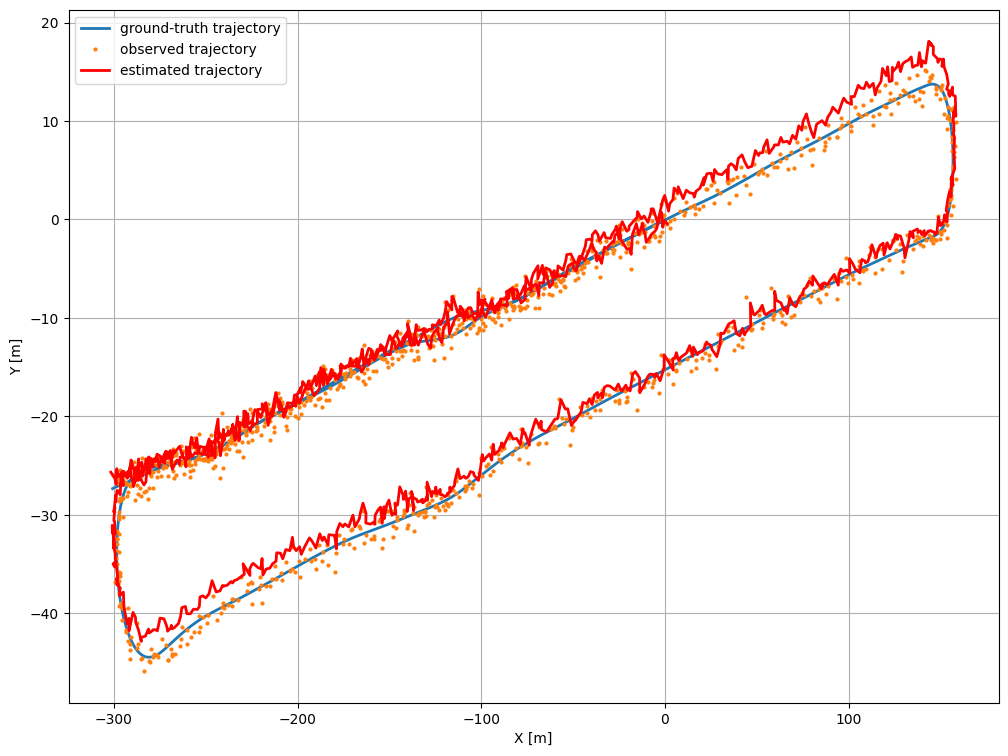

In [344]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

xs, ys, _ = gt_trajectory_xyz
ax.plot(xs, ys, lw=2, label='ground-truth trajectory')

xs, ys, _ = obs_trajectory_xyz
ax.plot(xs, ys, lw=0, marker='.', markersize=4, alpha=1., label='observed trajectory')

ax.plot(mu_x_2, mu_y_2, lw=2, label='estimated trajectory', color='r')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()
ax.grid()

In [345]:
error_kf2 = mean_squared_error(gt_trajectory_xyz[:2, :], np.array([mu_x_2, mu_y_2]))
print(f"MSE: {error_kf2}")

MSE: 1.9803797602925437
